Test Function


First cell: I defined the parameters like the dimension of the field, the number of stars, the exponents of the potential laws and the IMF function

In [100]:
# FIRST CELL
##* packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve

# dimension of the matrix
N = int(1e3+1)
# number of stars
M = int(1e3)

## Set parameters
alpha = 2
beta  = 3
# minimum and maximum masses 
m_min = 0.1; m_max = 20
# Initial Mass Function
IMF = lambda m : m**(-alpha)
IMF_min = IMF(0.1); IMF_max = IMF(20) 




Second and Third cells: I defined the function for the random generation of the masses and then I created the luminosity array

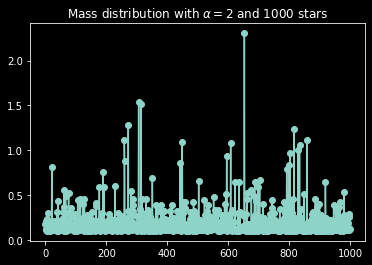

In [101]:
# SECOND CELL
##* Genration of masses array with IMF distribution
#   The function takes the minimum and the maximum of the
#   IMF, generates a M-dimension array of random value for imf in
#   [IMF_min,IMF_max] and returns a M-dimension array of masses,
#   distribuited like the IMF   
#	param	min	minimum imf value
# 	param	max	maximum	imf value
# 
# 	return	m	M array of masses distributed like imf   
def generate_mass_array(min,max):
	np.random.seed()
	imf = np.random.rand(M)*(max-min)+min
	return imf**(-1/alpha)

# M array of masses in solar mass unit
m = generate_mass_array(IMF_min,IMF_max)

## Plot data

plt.title(f'Mass distribution with $\\alpha = {alpha}$ and {M} stars')
plt.plot(m,'o-')

plt.show()



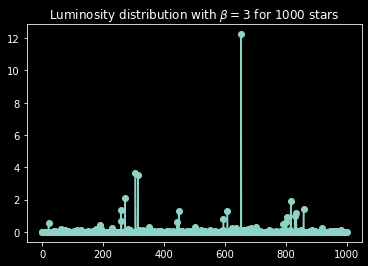

In [102]:
# THIRD CELL
# M array of luminosities in solar luminosity unit
L = m**beta

## Plot data
plt.title(f'Luminosity distribution with $\\beta = {beta}$ for {M} stars')
plt.plot(L,'o-')

plt.show()

Fourth cell: I defined the star class object, a class that contains all infos about star (mass,lum and position) and I implemented the function to set stars positions and the function to update the field matrix with the stars luminosities in mag. 
Since the function plt.imshow() takes float values from 0 to 1 to generate an image in grayscale, I decided to write the transfer_function(), that transforms luminosities into values in [0,1].

In [103]:
# FOURTH CELL
##* Star class obj to collect star informations
class star(object):
#		param	mass	star mass
#		param	lum	star luminosity
# 		param	x,y 	star coordinates in the field 	
	def __init__(self,mass, lum, x ,y):
		self.m   = mass		# star mass value
		self.lum = lum		# star luminosity value
		self.x = x		# star x coordinate
		self.y = y		# star y coordinate

##* Function to locate the stars
#   It generates 2 random arrays of dimension n: 
#   one is the x coordinate array and 
#   y coordinate array of each star
#	param	n	number of stars
#
#	return	X,Y	stars coordinate arrays
#? I have to check this function: the condition replace=False forbids M > N  
def star_location(n):
	tmp = np.random.default_rng()
	X = tmp.choice(N, size=n)
	Y = tmp.choice(N, size=n, replace=False)
	return X, Y	

##* Transfer function
#?  Understand if it is reasonable 
'''   
	The implementation of this function is my choice. The function plt.imshow() takes float values in [0,1] to make grayscale image.
	I decided to convert luminosities into values in [0,1], using logaritmic values of them: 
		- I set a minimum detectable value of luminosity (called inf)
		  Luminosities < inf are represented as black pixels
		- I normaled with the maximum value of luminosity (called sup)
		  Luminosities = sup are converted in 1 (namely white)
'''
#   It converts luminosities in a scale from 0 to 1 to get grayscale
#   with function plt.imshow()
# 	param	l	array of luminosities
# 
# 	return	mag	converted magnitudes array   
def transfer_function(l):
	inf = 9e-5	# threshold to detect luminosity
	sup = 8000	# maximum luminosity
	# control the presence of 0s, change them with inf and save in an other temporary array
	tmp = np.where(l==0,inf,l)
	# convertion
	mag = (np.log10(tmp)-np.log10(inf)) / (np.log10(sup)-np.log10(inf))
	# control the presence of negative values in mag and change them with 0
	return np.where(mag<0,0,mag)



##* Function to update the field
#   It adds the generated stars to the field
#   The shape of the field matrix is discussed
#   in the next cell
#	param	F	field matrix [N,N,3]
#	param	X,Y	coordinate arrays
#	param	l	luminosity array 
# 
# 	return	F	updated field matrix [N,N,3]
def update_field(F,X,Y,l):
	mag = transfer_function(l)
	# values are saved in each color channel 
	# to have grayscale
	for i in range(3):
		F[X,Y,i] = mag
	return F



Fifth cell: I implemented the initialization function to generate the masses, the field and the image without any psf or noise.

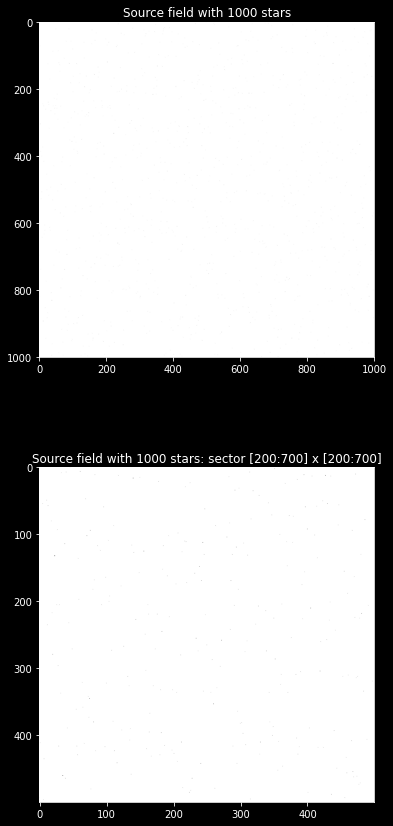

In [104]:
# FIFTH CELL

##* Initialization function: generation of the "perfect" sky
#   It generates the stars and initialized the field to make
#   the sky image without any psf and noise
#	param	VOID
#	
#	return	F	field matrix
#	return	S	star class obj with stars infos
def initialize():
	# generate a [N,N,3] matrix of 0s
	# the third index is use for the RGB
	F = np.zeros([N,N,3])
	# generate masses
	m = generate_mass_array(IMF_min,IMF_max)
	# set luminosities
	L = m**beta
	# generate stars coordinates
	xs,ys = star_location(M)
	# put stars in the field
	F = update_field(F,xs,ys,L)
	# save stars infos
	S = star(m,L,xs,ys)
	return F, S

# generation of the field and the stars
F, S = initialize()

## Plot
# variables to zoom a sector [inf:sup] x [inf:sup] of the field
inf = int(0.2*N)
sup = int(0.7*N)

fig, (img_field, img_zoom) = plt.subplots(2,1,figsize=(6,15))
img_field.imshow(1-F)
img_field.set_title(f'Source field with {M} stars')
img_zoom.imshow(1-F[inf:sup,inf:sup,:])
img_zoom.set_title(f'Source field with {M} stars: sector [{inf}:{sup}] x [{inf}:{sup}]')
plt.show()

Sixth cell: I implemented the function for the atmosferic seeing by gaussian distribution

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


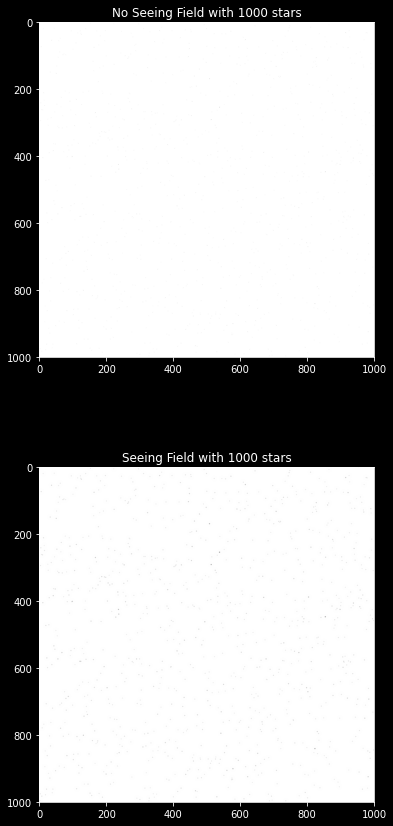

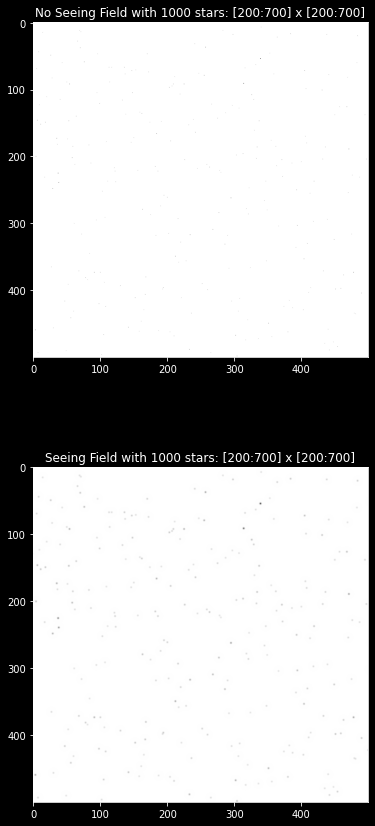

In [105]:
# SIXTH CELL
##* Gaussian matrix generator
#   It makes a gaussian [n,n] matrix, centered in [xs,ys]
# 	param	n	dimension of matrix field
#	param	xs,ys	center coordinates
#	param	sigma	the root of variance, set to 0.9
#
#	return	G[n,n]	gaussian [n,n] matrix
def gaussian(n,xs,ys,sigma=0.9):
	x = np.arange(n,dtype=int)
	y = np.arange(n,dtype=int)
	x -= xs;  y -= ys
	# Gaussian function
	G = lambda r : np.exp(-r**2/sigma**2/2)
	# generate [n,n] matrix = G_i * G_j
	return np.outer(G(x),G(y))


##* Atmosferic seeing function
#   It convolves the field with tha Gaussian to
#   make the atmosferic seeing
#	param	f	field matrix [n,n,3]
#	
#	return	f_s	field matrix [n,n,3] with seeing
#?  Add a parameter to choose atm pfs between Gaussian and Lorentzian
def atm_seeing(f):
	# dim of the field
	n = len(f)
	# call f_s the new field with seeing
	f_s = f
	# take [n,n] matrix from the field
	field = f_s[:,:,0]
	# convolution with gaussian
	field = fftconvolve(field,gaussian(n,int(n/2),int(n/2)),mode='same')
	# values are saved in each color channel 
	# to have grayscale
	for i in range(3):
		f_s[:,:,i] = field
	return f_s

# generation of the field and the stars
F, S = initialize()

## Plot
fig1, (img_field, img_field_seeing) = plt.subplots(2,1,figsize=(6,15))
fig2, ( img_zoom, img_zoom_seeing)  = plt.subplots(2,1,figsize=(6,15))

img_field.imshow(1-F)
img_field.set_title(f'No Seeing Field with {M} stars')
img_zoom.imshow(1-F[inf:sup,inf:sup,:])
img_zoom.set_title(f'No Seeing Field with {M} stars: [{inf}:{sup}] x [{inf}:{sup}]')

# generation of the seeing image
F_s = atm_seeing(F)
img_field_seeing.imshow(1-F_s)
img_field_seeing.set_title(f'Seeing Field with {M} stars')
img_zoom_seeing.imshow(1-F_s[inf:sup,inf:sup,:])
img_zoom_seeing.set_title(f'Seeing Field with {M} stars: [{inf}:{sup}] x [{inf}:{sup}]')

fig1.savefig('./Pictures/field.png')
fig2.savefig('./Pictures/zoom.png')

plt.show()
	
	

Seventh cell: I implemented function to add noise, both background and detector noise.

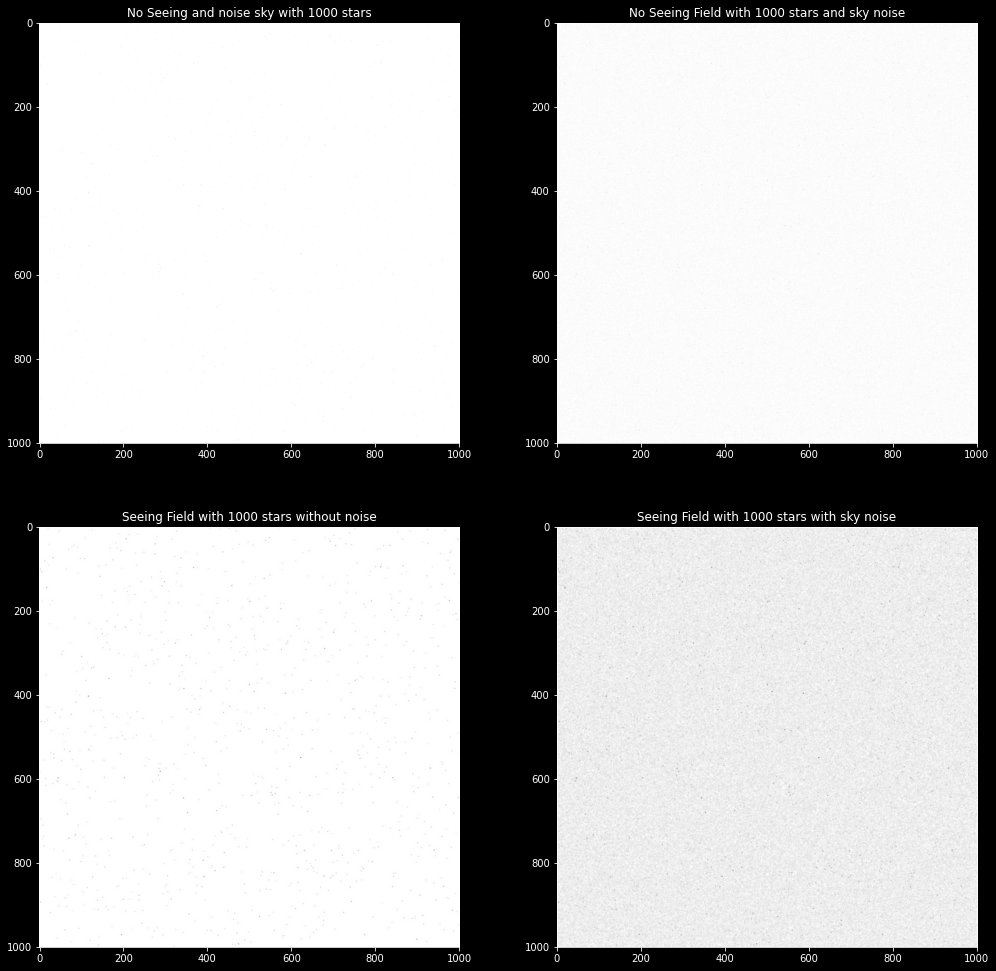

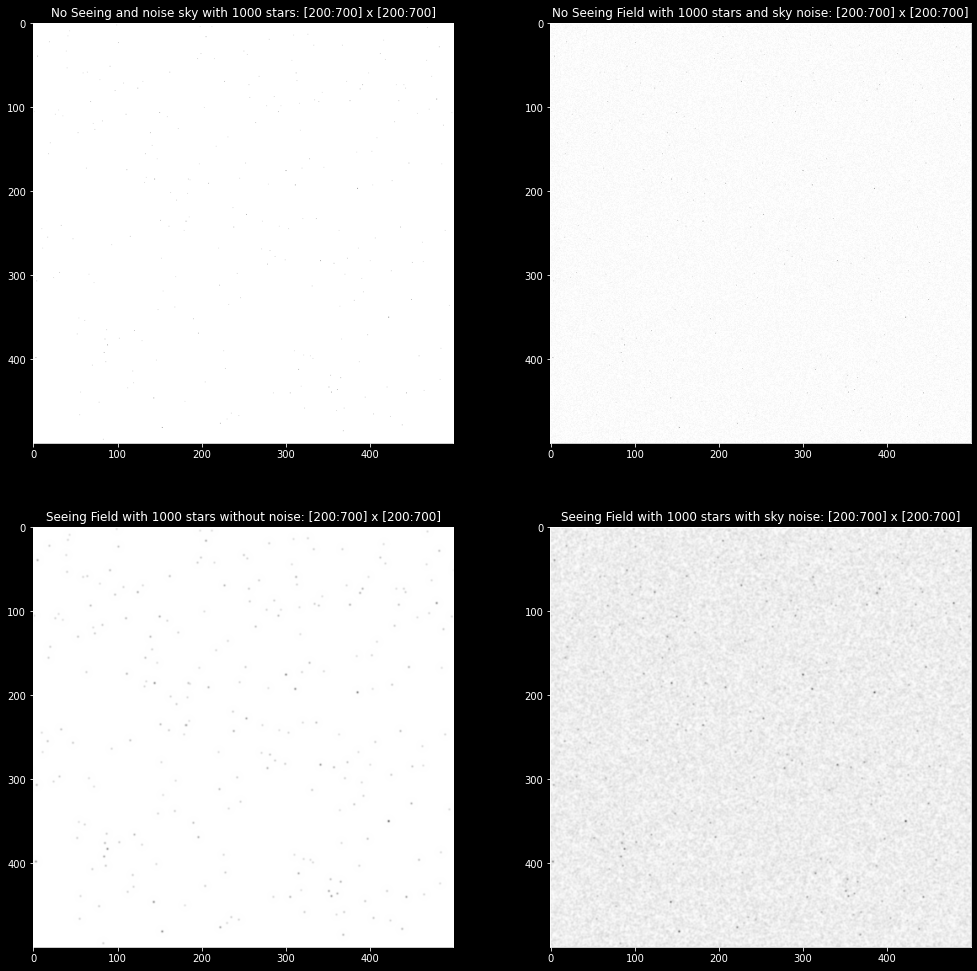

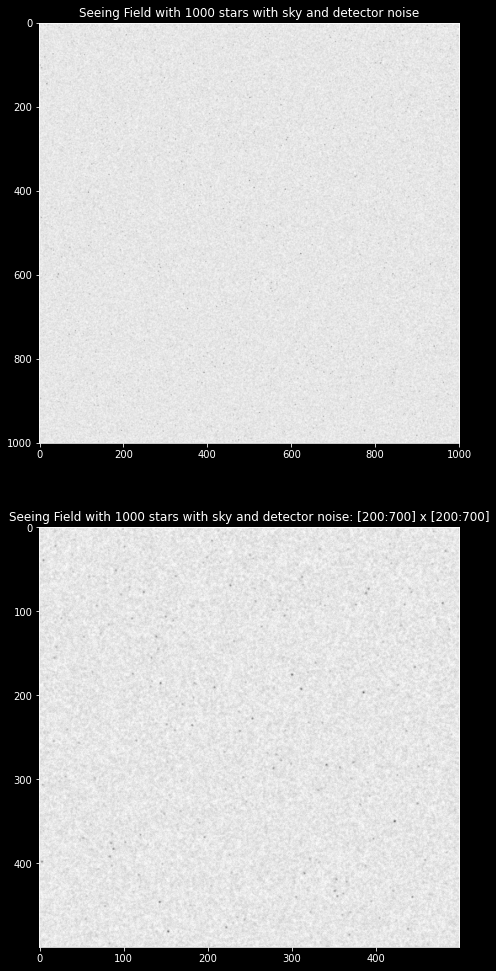

In [106]:
# SEVENTH CELL

##* Noise generator
#   It generates a [N,N,3] matrix of noise, using
#   an arbitrary value n (set to 2 * 10**-4) times
#   a random value in [0,1]
#	param	n	value of noise, set to 2e-4
#
#	return	Noise	[N,N,3] matrix of noise
def noise(n = 2e-4):
	np.random.seed()
	# random multiplicative [N,N] matrix
	N0 = np.random.random((N,N))
	# generate a [N,N,3] matrix of 0s
	Noise = np.zeros([N,N,3])
	# generate noise
	Noise[:,:,0] = N0*n
	# values are saved in each color channel 
	# to have grayscale
	for i in range(1,3):
		Noise[:,:,i] = Noise[:,:,0]
	return Noise


# generation of the field and the stars
F, S = initialize()

# add background noise
F_n = F + transfer_function(noise())

## Plot
fig1, ((img_field, img_field_noise),(img_field_seeing,img_field_snoise)) = plt.subplots(2,2,figsize=(17,17))
fig2, ((img_zoom, img_zoom_noise)  ,(img_zoom_seeing,img_zoom_snoise))   = plt.subplots(2,2,figsize=(17,17))
fig3, (img_field_tot, img_zoom_tot) = plt.subplots(2,1,figsize=(8,17))


img_field.imshow(1-F)
img_field.title.set_text(f'No Seeing and noise sky with {M} stars')
img_zoom.imshow(1-F[inf:sup,inf:sup,:])
img_zoom.title.set_text(f'No Seeing and noise sky with {M} stars: [{inf}:{sup}] x [{inf}:{sup}]')


img_field_noise.imshow(1-F_n)
img_field_noise.title.set_text(f'No Seeing Field with {M} stars and sky noise')
img_zoom_noise.imshow(1-F_n[inf:sup,inf:sup,:])
img_zoom_noise.title.set_text(f'No Seeing Field with {M} stars and sky noise: [{inf}:{sup}] x [{inf}:{sup}]')

# generate atmosferic seeing image without sky noise
F_s = atm_seeing(F)
img_field_seeing.imshow(1-F_s)
img_field_seeing.title.set_text(f'Seeing Field with {M} stars without noise')
img_zoom_seeing.imshow(1-F_s[inf:sup,inf:sup,:])
img_zoom_seeing.title.set_text(f'Seeing Field with {M} stars without noise: [{inf}:{sup}] x [{inf}:{sup}]')

# generate atmosferic seeing image with sky noise
F_sn = atm_seeing(F_n)
img_field_snoise.imshow(1-F_sn)
img_field_snoise.title.set_text(f'Seeing Field with {M} stars with sky noise')
img_zoom_snoise.imshow(1-F_sn[inf:sup,inf:sup,:])
img_zoom_snoise.title.set_text(f'Seeing Field with {M} stars with sky noise: [{inf}:{sup}] x [{inf}:{sup}]')

# add detector noise, set to 3e-4 (> than background one)
F_sn += transfer_function(noise(3e-4))
img_field_tot.imshow(1-F_sn)
img_field_tot.title.set_text(f'Seeing Field with {M} stars with sky and detector noise')
img_zoom_tot.imshow(1-F_sn[inf:sup,inf:sup,:])
img_zoom_tot.title.set_text(f'Seeing Field with {M} stars with sky and detector noise: [{inf}:{sup}] x [{inf}:{sup}]')


fig1.savefig('./Pictures/field_noise.png')
fig2.savefig('./Pictures/zoom_noise.png')
fig3.savefig('./Pictures/image.png')

plt.show()
